In [1]:
# read the path file with python
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
from scipy import signal
from scipy import linalg
import scipy as scipy
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import gc
import struct

In [2]:
class readpath(object):
    
    def __init__(self,N):
        self.N = N
        return None
    
    def generate_path(self):
        dict1 = {0:'C:\\Users\\Administrator\\source\\data\\path.dat',1:'C:\\Users\\Administrator\\source\\data\\path1.dat'}
        self.dict1 = dict1
        return dict1
    
    def read0(self,i):
        q = 0
        with open(self.dict1[i], "rb") as file0:
            data1 = file0.read(4)
            I = struct.unpack("i", data1)[0]
            data1 = file0.read(4)
            J = struct.unpack("i", data1)[0]
            data1 = file0.read(4)
            K = struct.unpack("i", data1)[0]
            h = []
            for i in range(I):
                a = []
                for j in range(J):
                    l = []
                    while(1):
                        data1 = file0.read(4)
                        f = struct.unpack("4s",data1)[0]
                        if (f!=b'end\x00'):
                            f = struct.unpack("f",data1)[0]
                            l.append(f)
                        else:
                            break
                    
                        

                    a.append(l)
                h.append(a)
                
        return I, h
    
    def read1(self):
        self.generate_path()
        h = [None]*self.N
        I = np.zeros((self.N,))
        for i in range(0,self.N):
            I[i],h[i] = self.read0(i)
            
        self.h = h
        self.I = I
        return h,I
    


In [186]:
file0 = open('C:\\Users\\Administrator\\source\\data\\path.dat', "rb") 

file0.seek(0,0)
data2 = file0.read(-1)

file0.close()


In [188]:
print(len(data1)) # correct
print(len(data2)) # 

11532
11532


In [157]:
print(data1[0])
print(data2[0])

2
1


In [189]:
flag = 0
for i in range(11532):
    if(data1[i]!=data2[i]):
        flag = flag+1
    if(flag==2):
        break
    

In [190]:
print(i)


11531


In [5]:
N = 1
s1 = readpath(N)
h,I = s1.read1()


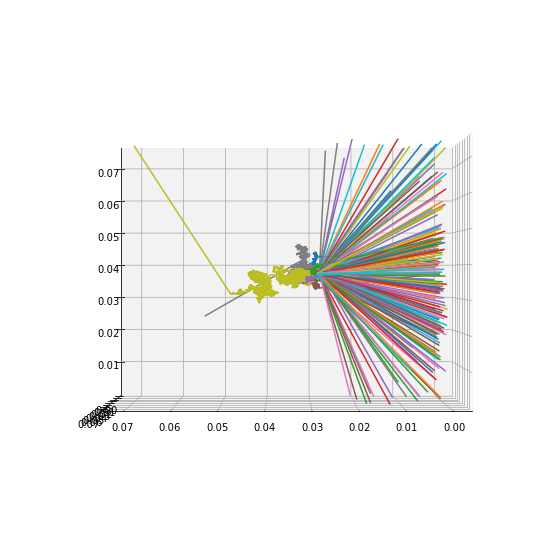

In [6]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
h1 = h[0]
k = 8990
l = 11000
for i in range(int(I[0])):
    # Data for a three-dimensional line
    zline = h1[i][0]
    xline = h1[i][1]
    yline = h1[i][2]
    ax.view_init(0,90) # (0,90) (45,225)
    ax.plot3D(xline, yline, zline)
    
plt.axis('on')
plt.show()

In [7]:
def analysis(h,I):
    eye = [0.0375,0.049,0.0375]
    #normal line vector (0.707,0.707,0)
    #euqation of surface : x+y=0.09
    N=480
    time = np.linspace(1e-12, 4800e-12, num=N)
    weight = np.zeros((N,))
    temp = pow(2,0.5)
    radius_fiber = 0.02
    threshold = 0.001
    for i in range(int(I)):
        for k in range(len(h[i][0])):

            if((pow(h[i][0][k]-eye[0],2)+pow(h[i][1][k]-eye[1],2)
               +pow(h[i][2][k]-eye[2],2) < pow(radius_fiber,2)) and 
               (abs(h[i][1][k]-eye[1])<threshold)):

                for t in range(N-1):
                    if(h[i][4][k]>=time[t]and(h[i][4][k]<time[t+1])):
                        weight[t]=weight[t]+h[i][3][k]
#                     break;

    return weight

def analysis_g(N, h, I):
    w2 = np.zeros((N,480))
    for i in range(0,N):
        w2[i] = analysis(h[i],I[i])

    return w2

In [8]:
w2 = analysis_g(N,h,I)

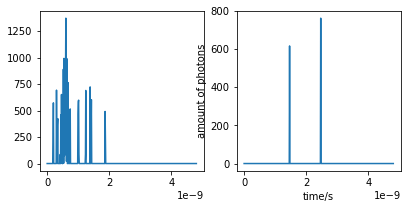

In [9]:
# plt.scatter(time,weight)
M=480
# N = 1
time = np.linspace(1e-12, 4800e-12, num=M)
core = np.array([1,2,3,4,5,4,3,2,1])
core = core/np.sum(core)
plt.figure(figsize = (10,10))
for i in range(N):
    plt.subplot(3,3,i+1)
    plt.plot(time,w2[i])
#     plt.plot(np.convolve(w2[i],core, mode = 'same'))
plt.xlabel('time/s')
plt.ylabel('amount of photons')
plt.show()

In [10]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [13]:
def name_g(i):
    if(i<=4 and i>=0):
        return  '0'+str(2*i+1)
    elif(i>4):
        return str(2*i+1)
    else:
        return None
    

dict1 = {i:'hyperspec1\\t5ns_scat'+ name_g(i) +'_abs_00.txt' for i in range(0, 8)}
dict1[-1] = 'hyperspec1\\ref_real_5ns.txt'


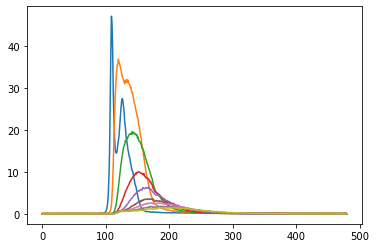

In [14]:
scat = [None]*9
data_480multi9 = np.zeros((9,480), dtype = float)
for i in range(0,9):
    scat[i] = process_hyperspec(dict1[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index
plt.figure('ns/nm')
for i in range(0,9):
    plt.plot(data_480multi9[i,:])
    
plt.show()
    

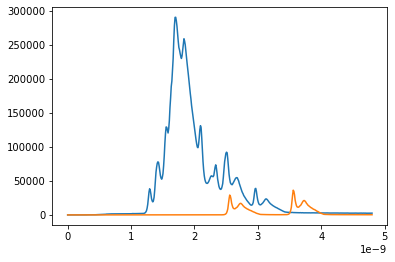

In [18]:
time = np.linspace(1e-12, 4800e-12, num=480)
plt.plot(time,np.convolve(data_480multi9[0],w2[0],mode = 'full')[:480])
plt.plot(time,np.convolve(data_480multi9[0],w2[1],mode = 'full')[:480])
plt.show()

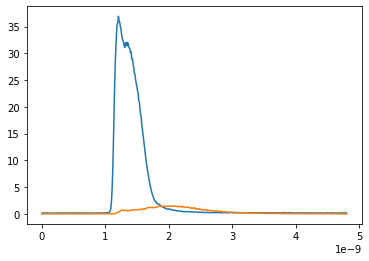

In [16]:
time = np.linspace(1e-11, 480e-11, num=480)
plt.plot(time,data_480multi9[1,:])
plt.plot(time,data_480multi9[8,:])    
plt.show()